In [25]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from scipy.sparse import csr_matrix as smatrix
import scipy.sparse.linalg as splinalg
from sklearn.cluster import KMeans

import os
import sys
sources = os.path.join(os.pardir, "modules")
if sources not in sys.path:
    sys.path.insert(0, sources)
import fem

In [26]:
# Units m->pixel=m/pix2m
# Pa=kg/m/s^2->kg/pixel/s^2=Pa*pix2m
# N = kg.m/s^2->kg.pixel/s^2=N/pix2m
# N/m = kg/s^2->kg/s^2=N/m
Ns=50
inp='../data/dic-coarse.res'
pix2m=25.e-6; # pixel to m conversion
thickness=3e-3 # speimen thicness in m
Fres=40/thickness

(X,conn)=fem.readDICmesh(inp)
model=fem.FEModel()
model.X=X
model.conn=conn
model.Assemble()
W=model.W
B=model.B

U=fem.readDICDisp(inp)
Fres=40/thickness


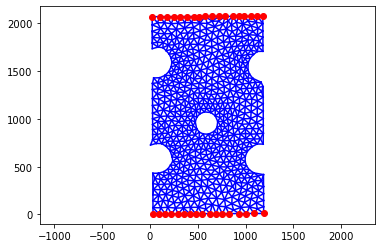

In [27]:

Nnodes=X.shape[0]
Nelems=conn.shape[0]
top=X[:,1]>max(X[:,1])*0.99
bot=X[:,1]<max(X[:,1])*0.01
Uy=U[Nnodes:]
L=max(X[:,1])-min(X[:,1])
dL=np.mean(Uy[top])-np.mean(Uy[bot])
section=max(X[:,0])-min(X[:,0])
Co=(Fres/section)/(dL/L)*pix2m
E_e=B.dot(U)
S_e=np.zeros(Nelems)

plt.plot(X[conn,0].T,X[conn,1].T,'b-');
plt.plot(X[top,0],X[top,1].T,'ro');
plt.plot(X[bot,0],X[bot,1].T,'ro');
plt.axis('equal');


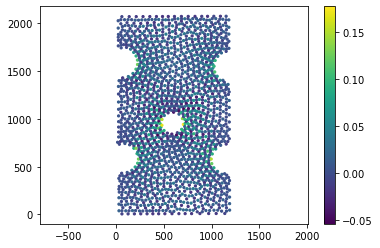

In [28]:
Xg=0.5*(X[conn[:,0]]+X[conn[:,1]])
ff=plt.figure();
plt.scatter(Xg[:,0],Xg[:,1],c=E_e,s=5);
plt.colorbar();
plt.axis('equal');



/home/jrethore/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


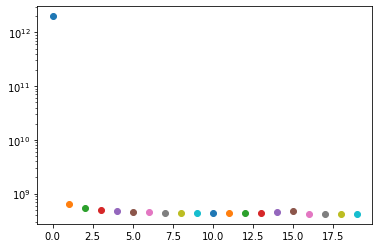

In [29]:
nodes_index=np.arange(Nnodes)
top_nodes=nodes_index[top]
ntop=top_nodes.size
free=np.logical_not(np.logical_or(top, bot))
free_nodes=nodes_index[free]
nfree=free_nodes.size
Free_x=smatrix((np.ones(nfree),(np.arange(nfree),free_nodes)),shape=(2*nfree+1,2*Nnodes))
Free_y=smatrix((np.ones(nfree),(np.arange(nfree)+nfree,free_nodes+Nnodes)),shape=(2*nfree+1,2*Nnodes))
Const_y=smatrix((np.ones(ntop),(2*nfree*np.ones(ntop),top_nodes+Nnodes)),shape=(2*nfree+1,2*Nnodes))
        
Dc=(Free_x+Free_y+Const_y)*(B.T*W)
D=B.T*W
Fext=np.zeros(2*nfree+1)
Fext[-1]=Fres

iW=scipy.sparse.spdiags(1/W.diagonal(),0,Nelems,Nelems)
C=Dc*(iW*Dc.T)
LU=splinalg.splu(C)

E_e=B.dot(U)
S_e=np.zeros(Nelems)
ff=plt.figure()
plt.yscale('log')
ic=0
for resampling in range(20):
    samples=np.c_[np.squeeze(E_e*np.sqrt(Co)),np.squeeze(S_e/np.sqrt(Co))]
    kmeans = KMeans(Ns).fit(samples)
    #.reshape(-1,1))
    ie=kmeans.labels_
    val=np.ones(Nelems)
    ii=np.arange(Nelems)
    P=smatrix((val,(ii,ie)),shape=(Nelems,Ns))

    Estar=splinalg.spsolve(P.T*P,P.T.dot(E_e))
    Sstar=splinalg.spsolve(P.T*P,P.T.dot(S_e))


    for iter in range(1):
        Estar_e=P.dot(Estar)
        Sstar_e=P.dot(Sstar)
        b=Dc.dot(Sstar_e)-Fext
        Lag=LU.solve(b)
        S_e=Sstar_e-iW*(Dc.T.dot(Lag))
        Sstar=splinalg.spsolve(P.T*P,P.T.dot(S_e))
        ddi_norm=0.5*(Co*np.dot(E_e-Estar_e,W.dot(E_e-Estar_e))+1/Co*np.dot(S_e-Sstar_e,W.dot(S_e-Sstar_e)))
        plt.plot(ic,ddi_norm,'o')
        ic+=1


    




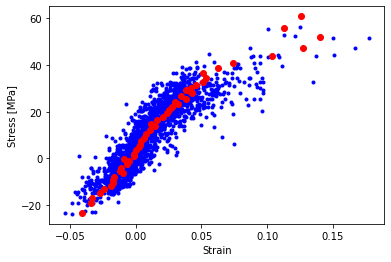

In [30]:
ff=plt.figure()
plt.plot(E_e,S_e/pix2m*1.e-6,'b.')
plt.plot(Estar,Sstar/pix2m*1.e-6,'ro');
plt.xlabel('Strain')
plt.ylabel('Stress [MPa]');



In [31]:
np.savez('ddi-from-dic',Sstar=Sstar,Estar=Estar)
